## Modeling Script
This script is used to performe grid search to find the optimal values for the hyper-parameters of 4 regression algorithm models.
The models tried and their tuned hyperparameters are:
1. Linear Regression |  ---
2. Decision Tree &emsp;&nbsp;&nbsp;&nbsp;| max_depth:[5, 10, 15, 20, 40], min_samples_leaf:[1, 2, 4, 8]
3. Random Forest &emsp;| tmax_depth:[5, 10, 15, 20, 40], n_estimators:[100, 200, 400, 800]
4. XGBoost &emsp;&emsp;&emsp;&emsp;| max_depth:[5, 7, 8, 10, 15], n_estimators:[100, 200, 400, 800], learning_rate:[0.01, 0.05, 0.1, .2, .4, .8], colsample_bytree:[.5, .6, .8]

In [1]:
# Importing needed modules and the dataset.

import pandas as pd
import os, time
import matplotlib.pyplot as plt
import seaborn as sns
from preprocess import preprocess_dataframe
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


df = pd.read_csv("..\\listings.csv", sep = ',', header = 0, encoding = 'unicode_escape')

In [2]:
# Calling the preprocessing function on the dataset. It returns the preprocessed dataset and a boolean informing the user of any existing NAN values.

df, has_nan_values = preprocess_dataframe(df)

#Handling the case of existing NaN values.
if has_nan_values:
    print("Droping rows with NaN values for training. You should provide data with no missing values for the columns:\n",df.columns[:-1].values)
    df.dropna(how="any",inplace = True)

Droping rows with NaN values for training. You should provide data with no missing values for the columns:
 ['host_since' 'host_response_time' 'host_response_rate'
 'host_is_superhost' 'host_listings_count' 'host_has_profile_pic'
 'host_identity_verified' 'neighbourhood_cleansed' 'latitude' 'longitude'
 'room_type' 'accommodates' 'amenities' 'minimum_nights' 'maximum_nights'
 'has_availability' 'availability_30' 'availability_60' 'availability_90'
 'availability_365' 'number_of_reviews' 'number_of_reviews_ltm'
 'number_of_reviews_l30d' 'instant_bookable' 'reviews_per_month'
 'bathrooms' 'shared_bath']


In [3]:
# Define a single grid search function to call for each model. The outliers
# (price > 150) are droped only for the training sets.
#--------------------------------------------------
# Arguements
# df:           The preprocessed dataframe.
# model_arg:    The function defining the model e.g. RandomForestRegressor().
# dict_params:  the parameters and their values to try in dictionary form.
#--------------------------------------------------
# Returns
# grid:                             The grid containing the tried models and their metrics.
# X_train, X_test, y_train, y_test  The split datasets originating from df.

def employ_grid_search(df, model_arg, dict_params):
    X = df.iloc[:,:-1].copy()
    y = df.target.copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)

    # Removing outliers from training set only.
    valid_indices = y_train[y_train <= 150].index
    X_train = X_train.loc[valid_indices,:]
    y_train = y_train.loc[valid_indices]

    if os.cpu_count() > 2:
        n_jobs = os.cpu_count() - 2
        print("Using",n_jobs,"threads to parallelize grid search.")
    else:
        n_jobs = 1
    grid = GridSearchCV(model_arg, dict_params, cv = 10, verbose = 4,
                        scoring = ["neg_mean_absolute_error","neg_median_absolute_error","neg_mean_absolute_percentage_error","neg_root_mean_squared_error"], refit = False,
                        n_jobs = n_jobs)
    grid.fit(X_train, y_train)

    return grid, X_train, X_test, y_train, y_test

In [4]:
# Identify the best model parameters based on score achieved durring cross-validation. It is chosen from the top 5 models
# based on rmse and mae.
#--------------------------------------------------
# Arguements
# gs:           The grid object corresponding to the parameter tuning and 10-fold CV.
#--------------------------------------------------
# Returns
# Nothing - It only prints the performance of all models based on rmse and mae metrics.

def print_grid_models_info(gs):
    print("\n========",gs.estimator,"========")
    temp = pd.DataFrame(gs.cv_results_)
    for metric in ["mean_test_neg_mean_absolute_error", "mean_test_neg_root_mean_squared_error"]:
        print("\t--------",metric,"--------")
        selected_params = temp.loc[temp.loc[:,metric].apply(lambda x: -x).sort_values(ascending = True).index.values[0:10],"params"]
        for i,par in enumerate(selected_params):
            print('\t'*2,par,temp.loc[:,metric].apply(lambda x: -x).sort_values(ascending = True).iloc[i])

### Running the grids

In [5]:
#Linear Regression --- No grid search is needed but included here for perspective reasons.

# We normalize the inputs.
lin_reg_params = {"normalize":[True]}
gridLR, X_trainLR, X_testLR, y_trainLR, y_testLR = employ_grid_search(df, LinearRegression(), lin_reg_params)
print_grid_models_info(gridLR)
time.sleep(1)
del gridLR

Using 10 threads to parallelize grid search.
Fitting 10 folds for each of 1 candidates, totalling 10 fits

======== LinearRegression() ========
	-------- mean_test_neg_mean_absolute_error --------
		 {'normalize': True} 23.154742950282255
	-------- mean_test_neg_root_mean_squared_error --------
		 {'normalize': True} 141.0909728852445


In [11]:
#Random Forest
rf_params = {'n_estimators':[100, 200, 400, 800], 'max_depth':[5, 10, 15, 20, 40]}
gridRF, X_trainRF, X_testRF, y_trainRF, y_testRF = employ_grid_search(df, RandomForestRegressor(), rf_params)
print_grid_models_info(gridRF)
time.sleep(1)
del gridRF


======== RandomForestRegressor() ========
	-------- mean_test_neg_mean_absolute_error --------
		 {'max_depth': 20, 'n_estimators': 400} 15.00369202667272
		 {'max_depth': 40, 'n_estimators': 400} 15.008526889353428
		 {'max_depth': 20, 'n_estimators': 800} 15.022483710773226
		 {'max_depth': 40, 'n_estimators': 800} 15.024543422071735
		 {'max_depth': 40, 'n_estimators': 200} 15.052770671656873
		 {'max_depth': 20, 'n_estimators': 200} 15.059772251229607
		 {'max_depth': 40, 'n_estimators': 100} 15.072379460486825
		 {'max_depth': 15, 'n_estimators': 400} 15.091625007528839
		 {'max_depth': 15, 'n_estimators': 800} 15.10493791085212
		 {'max_depth': 20, 'n_estimators': 100} 15.110201548943275
	-------- mean_test_neg_root_mean_squared_error --------
		 {'max_depth': 40, 'n_estimators': 400} 20.760619539115385
		 {'max_depth': 40, 'n_estimators': 800} 20.766191319072995
		 {'max_depth': 20, 'n_estimators': 400} 20.776577528142347
		 {'max_depth': 20, 'n_estimators': 800} 20.78275294162

In [7]:
#Decision Tree
tree_params = {'min_samples_leaf':[1, 2, 4, 8], 'max_depth':[5, 10, 15, 20, 40]}
gridDT, X_trainDT, X_testDT, y_trainDT, y_testDT = employ_grid_search(df, DecisionTreeRegressor(), tree_params)
print_grid_models_info(gridDT)
time.sleep(1)
del gridDT

Using 10 threads to parallelize grid search.
Fitting 10 folds for each of 20 candidates, totalling 200 fits

======== DecisionTreeRegressor() ========
	-------- mean_test_neg_mean_absolute_error --------
		 {'max_depth': 10, 'min_samples_leaf': 8} 17.808737763800895
		 {'max_depth': 10, 'min_samples_leaf': 4} 17.892726263847177
		 {'max_depth': 10, 'min_samples_leaf': 2} 18.20861364630054
		 {'max_depth': 5, 'min_samples_leaf': 1} 18.30293335793748
		 {'max_depth': 5, 'min_samples_leaf': 4} 18.304588294629827
		 {'max_depth': 5, 'min_samples_leaf': 2} 18.30739425297194
		 {'max_depth': 10, 'min_samples_leaf': 1} 18.31074533354099
		 {'max_depth': 5, 'min_samples_leaf': 8} 18.34783702604316
		 {'max_depth': 15, 'min_samples_leaf': 8} 18.402971229645132
		 {'max_depth': 20, 'min_samples_leaf': 8} 18.549396938643554
	-------- mean_test_neg_root_mean_squared_error --------
		 {'max_depth': 5, 'min_samples_leaf': 2} 24.760699964530254
		 {'max_depth': 5, 'min_samples_leaf': 4} 24.7629726433

In [10]:
#XGboost --- This can take quite some time to run due to multiple parameters tried.
xgb_params = {'n_estimators' : [100, 200, 400, 800], 'learning_rate' : [.01, .05, .1, .2, .4, .8], 'max_depth' : [5, 7, 8, 10, 15], 'colsample_bytree' : [.5, .6, .8]}
gridXGB, X_trainXGB, X_testXGB, y_trainXGB, y_testXGB = employ_grid_search(df, XGBRegressor(), xgb_params)
print_grid_models_info(gridXGB)
time.sleep(1)
del gridXGB

Using 10 threads to parallelize grid search.
Fitting 10 folds for each of 360 candidates, totalling 3600 fits

======== XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) ========
	-------- mean_test_neg_mean_absolute_error --------
		 {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 800} 14.154729035846426
		 {'colsample_bytree': 0.5, 'lear

In [13]:
#Training the 2 best models (the difference is in the number of features as the input)
#with the optimal values for the hyperparameters as found through grid search.

modelLR = LinearRegression(normalize = True)
modelTree = DecisionTreeRegressor( max_depth=10, min_samples_leaf=8)
modelRF = RandomForestRegressor(n_estimators=400, max_depth=40)
modelXGB = XGBRegressor(colsample_bytree= 0.5, learning_rate= 0.05, max_depth= 7, n_estimators= 800)

modelLR.fit(X_trainLR, y_trainLR)
modelTree.fit(X_trainDT, y_trainDT)
modelRF.fit(X_trainRF, y_trainRF)
modelXGB.fit(X_trainXGB, y_trainXGB)

predsLR = modelLR.predict(X_testLR)
predsTree = modelTree.predict(X_testDT)
predsRF = modelRF.predict(X_testRF)
predsXGB = modelXGB.predict(X_testXGB)

print("Linear Regresion")
print("Mean abs error:",mean_absolute_error(y_testLR, predsLR))
print("RMSE:",mean_squared_error(y_testLR, predsLR, squared=False))
print("-------------------------------------")
print("Decision Tree")
print("Mean abs error:",mean_absolute_error(y_testDT, predsTree))
print("RMSE:",mean_squared_error(y_testDT, predsTree, squared=False))
print("-------------------------------------")
print("Random Forest")
print("Mean abs error:",mean_absolute_error(y_testRF, predsRF))
print("RMSE:",mean_squared_error(y_testRF, predsRF, squared=False))
print("-------------------------------------")
print("XGBoost")
print("Mean abs error:",mean_absolute_error(y_testXGB, predsXGB))
print("RMSE:",mean_squared_error(y_testXGB, predsXGB, squared=False))

C:\Users\visdi\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Linear Regresion
Mean abs error: 52.71987482092808
RMSE: 403.1089874759779
-------------------------------------
Decision Tree
Mean abs error: 51.935683685773036
RMSE: 402.7373007510479
-------------------------------------
Random Forest
Mean abs error: 49.23041492693111
RMSE: 402.0998279788477
-------------------------------------
XGBoost
Mean abs error: 48.022905043122165
RMSE: 401.5909378193915


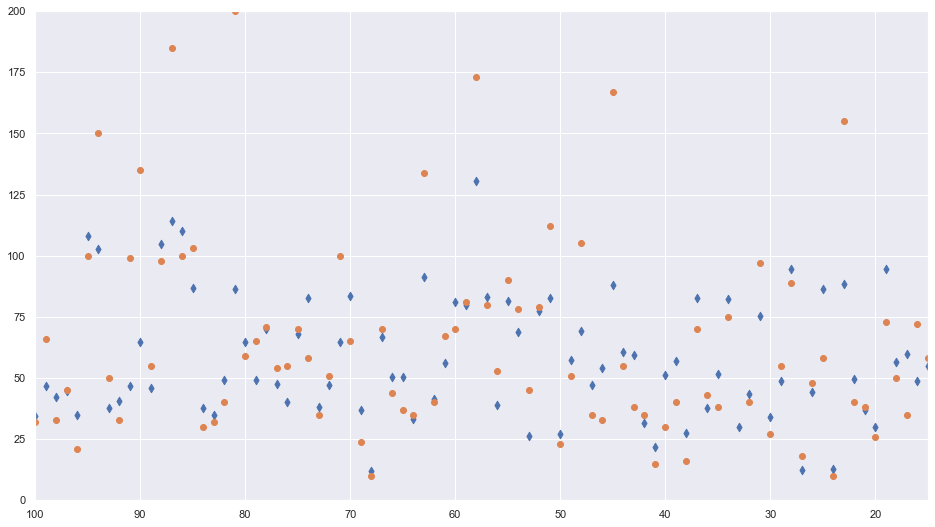

In [14]:
#Visualize a part of the predictions against their true values

sns.set(rc={"figure.figsize":(16, 9)})
plt.scatter(x = range(len(predsXGB)), y = (predsXGB), marker='d')
plt.scatter(x = range(len(predsXGB)), y = y_testXGB)
plt.ylim((0,200))
plt.xlim((100,15))
plt.show()

In [15]:
#Find the indices of the undervalued properties threshold is: pred > 1.3 * value

undervalued = []
for i,pred in enumerate(predsXGB):
    if pred > y_testXGB.values[i]*1.3:
        undervalued.append(i)
    
print("There are",len(undervalued),"undervalued listings on AirBnB.")


There are 635 undervalued listings on AirBnB.


In [16]:
# Saving the best model

from joblib import dump
dump(modelXGB, "XGBmodel.joblib")

['XGBmodel.joblib']